# Parse static networks

Parses nursing home interaction data that is temporally resolved to create a static interaction network between patients (and employees). The link strength corresponds to different shared living areas:
* close: shared room
* intermediate: shared table
* loose (far): shared living area

**Note**: Stronger links supercede weaker links and do not "add up"

In [5]:
import pandas as pd
import networkx as nx
import itertools
from os.path import join

src = '../data/living_conditions/'
dst = '../data/contact_networks'

In [11]:
import os
os.getcwd()

'/Users/ledebur/nursing_home_SEIRX'

## Helper functions

In [12]:
def ConstructNetwork(data, quarter, N_employees):
    '''
    Constructs a contact network based on interaction data.
    
    Parameters:
    -----------
    data : pandas DataFrame
        Table that holds information about close, intermediate and far contacts
        and resident IDs.
    quarter : int
        Number of the living area the contact interaction data belongs to.
    N_employees : int
        The interaction data does not contain information about employees. The
        Number of employees is known for the given nursing homes and passed to
        this function. All employees have contacts of type "loose" (far) to each
        other and of type "loose" (far) to all residents.
    '''
    G = nx.Graph()
    resident_IDs = data['resident_ID']
    
    ## resident contacts ###
    # order is important here, since strongest links are added first and then
    # not replaced by weaker links if they already exist
    contact_types = ['close','intermediate','far']
    link_types = {'close':'resident_resident_room', 
                  'intermediate':'resident_resident_table',
                  'far':'resident_resident_quarters'}
    for ct in contact_types:
        # iterate over all sub-units of the given contact type, for example the
        # different room or table numbers in the case of nursing homes
        for sub_ct in data[ct].unique():
            sub_ct_data = data[data[ct] == sub_ct]
            # create a list of all possible ID-tuples from all IDs that share
            # a given sub-unit (e.g. all residents that share a room or
            # all residents that have lunch on the same table)
            ID_tuples = [tuple(i) for \
                    i in itertools.combinations(\
                                    sub_ct_data['resident_ID'].values, 2)]
            # add all the links from the sub area to the graph
            for tup in ID_tuples:
                edge_data = G.get_edge_data(tup[0], tup[1])
                if edge_data == None:
                    G.add_edge(tup[0], tup[1], contact_type=ct, 
                               link_type = link_types[ct])
                    
    nx.set_node_attributes(G, 'Q{}'.format(quarter), 'unit')
    nx.set_node_attributes(G, 'resident', 'type')
    nx.set_node_attributes(G, 'age', 80)
    
    ## employee contacts ##
    # create a complete contact graph for the employees, as they all interact
    # with each other
    employee_IDs = ['e{}'.format(i) for i in \
                    range((quarter - 1) * N_employees, quarter * N_employees)]
    H = nx.complete_graph(employee_IDs)
    nx.set_node_attributes(H, {eID:{'type':'employee', \
                                    'unit':'Q{}'.format(quarter),
                                    'age':35}\
                           for eID in employee_IDs})
    nx.set_edge_attributes(H, 'far', 'contact_type')
    nx.set_edge_attributes(H, 'employee_employee_short', 'link_type')
    
    # add the employee contacts to the resident contacts
    G = nx.compose(G, H)
    for e in employee_IDs:
        for r in resident_IDs:
            # every employee has contact with every resident
            G.add_edge(e, r, contact_type='far', 
                       link_type='employee_resident_care')
    
    return G

In [13]:
def add_mobility_links(G, q1, q2, N):
    '''
    Adds a number of edges between residents with higher mobility that live in
    one living area and visit a friend in another living area.
    
    Parameters:
    -----------
    G : networkx Graph
        Graph holding the residents and employees as nodes and their contacts
        as edges.
    q1 : string
        Label of the first living area. Needs to be the value of the 
        corresponing node attribute "unit" in the contact Graph G.
    q2 : string
        Label of the second living area. Needs to be the value of the 
        corresponing node attribute "unit" in the contact Graph G.
    N : int
        Number of mobile residents.
    
    '''
    units = nx.get_node_attributes(G, 'unit')
    residents_LA1 = pd.Series([p for p in units.keys() if units[p] == q1])
    residents_LA2 = pd.Series([p for p in units.keys() if units[p] == q2])
    
    mobile_residents = residents_LA1.sample(N)
    friends = residents_LA2.sample(N)
    
    for m, f in zip(mobile_residents, friends):
        G.add_edge(m, f, area='facility')
        
    return G

## Load living condition data

In [14]:
LA = 2
data = pd.read_csv(join(src,'living_conditions_LA{}.csv'.format(LA)),
                  parse_dates=['week'])

data = data[data['week'] == pd.to_datetime('2020-02-03')]
data = data[data['living_area'] == LA]
data = data.rename(columns={'room_number':'close', 'table_number':'intermediate',
                           'living_area':'far'})
# rename patient IDs
data['resident_ID'] = ['r{}'.format(i) for i in range(1, len(data) + 1)]

FileNotFoundError: [Errno 2] No such file or directory: '../data/living_conditions/living_conditions_LA2.csv'

## Create contact networks

### Single quarters

In [17]:
G = ConstructNetwork(data, 1, 18)
nx.readwrite.gpickle.write_gpickle(G, join(dst,'interactions_single_quarter.bz2'\
                                  .format(LA)), protocol=4)

### Two quarters

In [40]:
data_q1 = data.copy()
data_q2 = data.copy()
data_q1['resident_ID'] = ['p{}'.format(i) for i in range(1, len(data_q1) + 1)]
data_q2['resident_ID'] = ['p{}'.format(i) for \
                          i in range(len(data_q2) + 1, 2 * len(data_q2) + 1)]
H = ConstructNetwork(data_q1, 1, 18)
I = ConstructNetwork(data_q2, 2, 18)

G = nx.compose(H, I)

# add random weak links between the four quarters through mobile patients
G = add_mobility_links(G, 'Q2', 'Q1', 10)

nx.readwrite.gpickle.write_gpickle(G, join(dst,'interactions_2_quarters.bz2'))

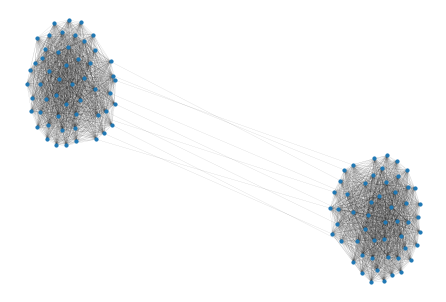

In [38]:
pos = nx.drawing.layout.spring_layout(G, dim=2)
nx.draw(G, pos, node_size=10, width=0.05)

### Three quarters

In [42]:
data_q1 = data.copy()
data_q2 = data.copy()
data_q3 = data.copy()
data_q1['resident_ID'] = ['p{}'.format(i) for i in range(1, len(data_q1) + 1)]
data_q2['resident_ID'] = ['p{}'.format(i) \
                    for i in range(len(data_q2) + 1, 2 * len(data_q2) + 1)]
data_q3['resident_ID'] = ['p{}'.format(i) \
                    for i in range(2 * len(data_q3) + 1, 3 * len(data_q3) + 1)]

H = ConstructNetwork(data_q1, 1, 18)
I = ConstructNetwork(data_q2, 2, 18)
J = ConstructNetwork(data_q3, 3, 18)

G = nx.compose(H, I)
G = nx.compose(G, J)

# add random week links between the four quarters through mobile patients
G = add_mobility_links(G, 'Q1', 'Q2', 10)
G = add_mobility_links(G, 'Q1', 'Q3', 10)
G = add_mobility_links(G, 'Q2', 'Q3', 10)

nx.readwrite.gpickle.write_gpickle(G, join(dst,'interactions_3_quarters.bz2'))

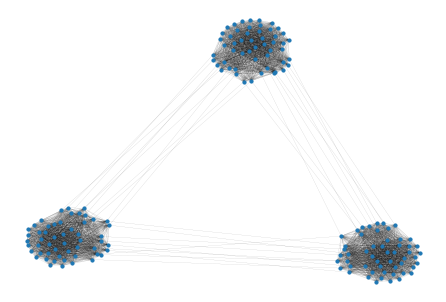

In [43]:
pos = nx.drawing.layout.spring_layout(G, dim=2)
nx.draw(G, pos, node_size=10, width=0.05)

### Four quarters

In [44]:
data_q1 = data.copy()
data_q2 = data.copy()
data_q3 = data.copy()
data_q4 = data.copy()
data_q1['resident_ID'] = ['p{}'.format(i) for i in range(1, len(data_q1) + 1)]
data_q2['resident_ID'] = ['p{}'.format(i) \
                for i in range(len(data_q2) + 1, 2 * len(data_q2) + 1)]
data_q3['resident_ID'] = ['p{}'.format(i) \
                for i in range(2 * len(data_q3) + 1, 3 * len(data_q3) + 1)]
data_q4['resident_ID'] = ['p{}'.format(i) \
                for i in range(3 * len(data_q4) + 1, 4 * len(data_q4) + 1)]

H = ConstructNetwork(data_q1, 1, 18)
I = ConstructNetwork(data_q2, 2, 18)
J = ConstructNetwork(data_q3, 3, 18)
K = ConstructNetwork(data_q4, 4, 18)

G = nx.compose(H, I)
G = nx.compose(G, J)
G = nx.compose(G, K)

# add random week links between the four quarters through mobile patients
G = add_mobility_links(G, 'Q1', 'Q2', 10)
G = add_mobility_links(G, 'Q1', 'Q3', 10)
G = add_mobility_links(G, 'Q1', 'Q4', 10)
G = add_mobility_links(G, 'Q2', 'Q3', 10)
G = add_mobility_links(G, 'Q2', 'Q4', 10)
G = add_mobility_links(G, 'Q3', 'Q4', 10)

nx.readwrite.gpickle.write_gpickle(G, join(dst,'interactions_4_quarters.bz2'))

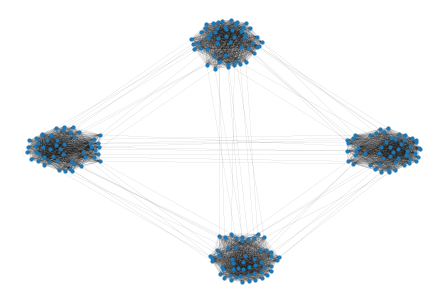

In [45]:
pos = nx.drawing.layout.spring_layout(G, dim=2)
nx.draw(G, pos, node_size=10, width=0.05)